# Проект для «Викишоп» BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
import re
import time
import torch
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from catboost import CatBoostClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, GridSearchCV

from transformers import BertTokenizer, BertModel
from tqdm import tqdm

warnings.filterwarnings('ignore')

## Подготовка

In [2]:
try:
    df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/toxic_comments.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [4]:
df.sample(5)

,Unnamed: 0,text,toxic
24968,24991,Fraternity \n\nI've reported you to the Admini...,0
61766,61833,Major Overhaul \n\nThis is obviously a work in...,0
105672,105769,White Plains logo \n\nThe White Plains logo ha...,0
155499,155657,"""\n\n About Operating Mode? \n\nDear Sir or Ma...",0
134874,135012,Finaly the Truth from Maratha Vishal1976 \n\n...,0


In [5]:
df.isnull().sum()

Unnamed: 0    0
text          0
toxic         0
dtype: int64

In [6]:
df.isna().sum()

Unnamed: 0    0
text          0
toxic         0
dtype: int64

In [7]:
df.duplicated().sum()

0

Визуализируем баланс классов целевого признака:

toxic
0    143106
1     16186
Name: count, dtype: int64

8.841344371679229

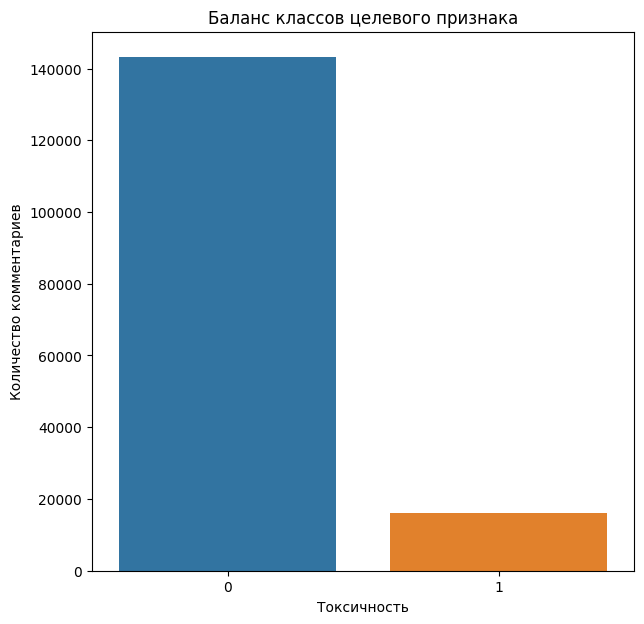

In [8]:
display(df['toxic'].value_counts())
display(df['toxic'].value_counts()[0] / df['toxic'].value_counts()[1])

plt.figure(figsize=(7, 7))
sns.countplot(x='toxic', data=df)

plt.title('Баланс классов целевого признака')
plt.xlabel('Токсичность')
plt.ylabel('Количество комментариев')

plt.show()

- датасет содержит 159292 строки и 3 столбца, 1 из которых дублирует индексы;
- в данных отсутствуют пропущенные значения и дубликаты;
- язык текстов - английский;
- в текстах содержаться разные регистры букв, символы пунктуации и '/n' и т.д.;
- в данных содержиться дисбаланс целевого признака в соотношении 1 к 8,84.

### Предобработка данных

В данных присутствует столбец, дублирующий номер строки, удалим его:

In [9]:
df = df.drop('Unnamed: 0', axis=1)
df.sample(5)

,text,toxic
25207,How surprising \n\nHow surprising that the art...,0
47145,Thanks for that lightning fast reply and inter...,0
125677,'press gang activities' ? Highly unlikely that...,0
97710,Plano\n\nMy edits were based on real events. A...,0
13699,"Start Page\nThis is a start page, so if anyone...",0


У столбца `'toxic` тип `int64`. Изменим тип на `uint8` для уменьшения "веса" датафрейма:

In [10]:
df['toxic'] = df['toxic'].astype('uint8')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  uint8 
dtypes: object(1), uint8(1)
memory usage: 1.4+ MB


Очистим текст с помощью регулярных выражений:

In [12]:
def cleaning(text):
    text = re.sub(r"(?:\n|\r)", " ", text)
    text = re.sub(r"[^a-zA-Z ]+", "", text).strip()
    text = text.lower()
    return text

df['text'] = df['text'].apply(cleaning)

## BERT

Для ускорения сократим датасет

In [13]:
df_bert_short = df.sample(n=7000, random_state=15423)

In [14]:
df_bert_short.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7000 entries, 120047 to 3403
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7000 non-null   object
 1   toxic   7000 non-null   uint8 
dtypes: object(1), uint8(1)
memory usage: 116.2+ KB


В качестве модели и токенайзера будем использовать "токсичный" BERT:

In [15]:
tokenizer = BertTokenizer.from_pretrained('unitary/toxic-bert', do_lower_case=True)
model = BertModel.from_pretrained('unitary/toxic-bert', output_hidden_states=False)

In [16]:
tokenized = df_bert_short['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True)))

Определим максимальную длину получившегося токена:

In [17]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

print('Максимальная длина токена:', max_len)

Максимальная длина токена: 512


Приведем токены к единой максимальной длине добавив нули:

In [18]:
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
padded = padded[:, :512]

"Маскировка" нулями и единицами токенов:

In [19]:
attention_mask = np.where(padded != 0, 1, 0)

In [20]:
%%time

batch_size = 100
embeddings = []
for i in tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])

        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])

        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)

        embeddings.append(batch_embeddings[0][:,0,:].numpy())

100%|████████████████████████████████████████████████████████████████████████████████| 70/70 [1:42:11<00:00, 87.59s/it]

CPU times: total: 6h 42min 58s
Wall time: 1h 42min 11s


Определим признаки и целевой признак, а также разделим их на обучающую и тестовую выборки:

In [21]:
features_b = np.concatenate(embeddings)
target_b = df_bert_short['toxic']

In [22]:
f_b_train, f_b_test, t_b_train, t_b_test = train_test_split(features_b,
                                                            target_b,
                                                            train_size=0.25,
                                                            random_state=15243)

### LogisticRegression

In [23]:
%%time

params = {'penalty': [None, 'l2'],
          'solver': ['newton-cg', 'lbfgs', 'liblinear'],
          'C': [5, 10, 15]}

logr = LogisticRegression()
logr_model = GridSearchCV(logr, param_grid=params, scoring='f1', cv=4).fit(f_b_train, t_b_train)
logr_model.best_score_

CPU times: total: 10 s
Wall time: 6.45 s


0.9198766377260287

### RandomForestClassifier

In [24]:
%%time

params = {'n_estimators': [10, 40, 100],
          'max_depth': [1, 4, 9]}

rfc = RandomForestClassifier()
rfc_model = GridSearchCV(rfc, param_grid=params, scoring='f1', cv=4).fit(f_b_train, t_b_train)
rfc_model.best_score_

CPU times: total: 37.3 s
Wall time: 37.5 s


0.9325886496508264

### CatBoostClassifier

In [25]:
%%time

params = {'verbose':[False],
          'random_state':[15243]}

cbc = CatBoostClassifier()
cbc_model = GridSearchCV(cbc, param_grid=params, scoring='f1', cv=4).fit(f_b_train, t_b_train)
cbc_model.best_score_

CPU times: total: 33min 1s
Wall time: 4min 43s


0.9371433241488816

Лучший результат оказался у модели CatBoostClassifier, протестируем на тестовых данных:

In [26]:
f1_score(t_b_test, cbc_model.best_estimator_.predict(f_b_test))

0.9066666666666666

## Выводы

**Вывод:**
В ходе работы над проектом:
- подготовили данные:
    - обработали регилярные выражения;
    - лемматизировали текст;
    - удалили дубликаты;
    - выяснили дисбаланс целевого признака;
    - разделили данные на выборки (обучающая и тестовая);
- выбрали модели для обучения:
    - LogisticRegression;
    - RandomForestClassifier;
    - CatBoostClassifier;
- обучили все 3 модели на обучающих данных и сравнили результаты;
- несмотря на ограниченность датасета (7000 строк) удалось достичь метрики F1 более 0.9 на всех 3х моделях. Лучшая модель `CatBoostClassifier` была протестированна на тестовых данных;
- на тестовых данных `CatBoostClassifier` показал результат F1: 0.907.